In [1]:
#import
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn import metrics
import shap

In [2]:
#Reading dataset
df=pd.read_csv('Hybrid_ESP.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Cate_name          68 non-null     object 
 1   Cate_HOMO          68 non-null     float64
 2   Cate_LUMO          68 non-null     float64
 3   Cate_ESP_O1        68 non-null     float64
 4   Cate_ESP_H1        68 non-null     float64
 5   Cate_ESP_O2        68 non-null     float64
 6   Cate_ESP_H2        68 non-null     float64
 7   Cate_BL_ArO1       68 non-null     float64
 8   Cate_BL_O1H1       68 non-null     float64
 9   Cate_BL_ArO2       68 non-null     float64
 10  Cate_BL_O2H2       68 non-null     float64
 11  Cate_total_dipole  68 non-null     float64
 12  P_name             68 non-null     object 
 13  P_HOMO             68 non-null     float64
 14  P_LUMO             68 non-null     float64
 15  P_ESP_P            68 non-null     float64
 16  P_ESP_=O           68 non-nu

In [3]:
#Building descriptors
X = df.drop(columns=['Yield', 'Cate_name', 'P_name' ])
print('---Descriptors---')
print(X.head())

y = pd.DataFrame(df['Yield'],columns=['Yield'])
print('---Objective---')
print(y.head())

---Descriptors---
   Cate_HOMO  Cate_LUMO  Cate_ESP_O1  Cate_ESP_H1  Cate_ESP_O2  Cate_ESP_H2  \
0      -5.63       0.21    -0.555170     0.441278    -0.594799     0.444770   
1      -5.63       0.21    -0.555170     0.441278    -0.594799     0.444770   
2      -5.63       0.21    -0.555170     0.441278    -0.594799     0.444770   
3      -5.63       0.21    -0.555170     0.441278    -0.594799     0.444770   
4      -5.51       0.22    -0.542028     0.433177    -0.582447     0.440296   

   Cate_BL_ArO1  Cate_BL_O1H1  Cate_BL_ArO2  Cate_BL_O2H2  ...  rdkit_catePC1  \
0         1.363         0.969         1.378         0.965  ...      -5.580019   
1         1.363         0.969         1.378         0.965  ...      -5.580019   
2         1.363         0.969         1.378         0.965  ...      -5.580019   
3         1.363         0.969         1.378         0.965  ...      -5.580019   
4         1.364         0.969         1.379         0.965  ...      -2.835492   

   rdkit_catePC2  rd

In [4]:
print(X.info())
print(X.isnull().any())
print(X.isnull().values.sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Cate_HOMO          68 non-null     float64
 1   Cate_LUMO          68 non-null     float64
 2   Cate_ESP_O1        68 non-null     float64
 3   Cate_ESP_H1        68 non-null     float64
 4   Cate_ESP_O2        68 non-null     float64
 5   Cate_ESP_H2        68 non-null     float64
 6   Cate_BL_ArO1       68 non-null     float64
 7   Cate_BL_O1H1       68 non-null     float64
 8   Cate_BL_ArO2       68 non-null     float64
 9   Cate_BL_O2H2       68 non-null     float64
 10  Cate_total_dipole  68 non-null     float64
 11  P_HOMO             68 non-null     float64
 12  P_LUMO             68 non-null     float64
 13  P_ESP_P            68 non-null     float64
 14  P_ESP_=O           68 non-null     float64
 15  P_ESP_H            68 non-null     float64
 16  P_BL_P=O           68 non-nu

In [5]:
#storage 
data_r2_train =[]
data_RMSE_train = []
data_MAE_train = []
data_r2_test = []
data_RMSE_test = []
data_MAE_test = []
best_model_parametors = []
data_cv_score = []

#SVM_a_X,log(y)
for i in range(10):
    seed=i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    
    #autoscaling
    a_X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
    a_X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
    
    log_y_train = np.log(y_train)
    
    param_svm={'C':[0.1,1,5,10,50,100,200,300,400,500,750,1000],
               'gamma':[100,10,1,0.1,0.01,0.001,0.0001,0.00001],
               'epsilon':[0.3]}
    reg_svm = GridSearchCV(SVR(kernel='rbf'), param_grid=param_svm, cv=5, n_jobs=2)
    reg_svm.fit(a_X_train,log_y_train['Yield'])
    reg_best = reg_svm.best_estimator_
    y_pred1 = np.exp(reg_best.predict(a_X_train))
    y_pred2 = np.exp(reg_best.predict(a_X_test))
    
    #train
    r2_train = metrics.r2_score(y_train, y_pred1)
    RMSE_train = metrics.mean_squared_error(y_train, y_pred1)
    MAE_train =  metrics.mean_absolute_error(y_train, y_pred1)
    #test
    r2_test = metrics.r2_score(y_test, y_pred2)
    RMSE_test = metrics.mean_squared_error(y_test, y_pred2)
    MAE_test = metrics.mean_absolute_error(y_test, y_pred2)
    
    parametors = reg_svm.best_params_
    best_model_parametors.append(parametors)
    cv_score = reg_svm.best_score_
    data_cv_score.append(cv_score)
    
    data_r2_train.append(r2_train)
    data_RMSE_train.append(RMSE_train)
    data_MAE_train.append(MAE_train)
    data_r2_test.append(r2_test)
    data_RMSE_test.append(RMSE_test)
    data_MAE_test.append(MAE_test)
    
    print('----------------------')
    print('seed:', seed)
    print("Best Model Parameter:",reg_svm.best_params_)
    print("Best Model Score:",reg_svm.best_score_)
    print('R2_test:', r2_test)
print('R2_train_means:', sum(data_r2_train)/10)
print('CV_score_means:', sum(data_cv_score)/10)
print('R2_test_means:', sum(data_r2_test)/10)

----------------------
seed: 0
Best Model Parameter: {'C': 1000, 'epsilon': 0.3, 'gamma': 0.0001}
Best Model Score: 0.9266762314985991
R2_test: 0.7741189330561514
----------------------
seed: 1
Best Model Parameter: {'C': 750, 'epsilon': 0.3, 'gamma': 0.0001}
Best Model Score: 0.900273102281214
R2_test: 0.8539553182758939
----------------------
seed: 2
Best Model Parameter: {'C': 1000, 'epsilon': 0.3, 'gamma': 0.0001}
Best Model Score: 0.9173904645255101
R2_test: 0.8107142102838358
----------------------
seed: 3
Best Model Parameter: {'C': 1000, 'epsilon': 0.3, 'gamma': 0.0001}
Best Model Score: 0.9045126808556079
R2_test: 0.8192626709773856
----------------------
seed: 4
Best Model Parameter: {'C': 750, 'epsilon': 0.3, 'gamma': 0.0001}
Best Model Score: 0.9228537406166236
R2_test: 0.7592693169451435
----------------------
seed: 5
Best Model Parameter: {'C': 750, 'epsilon': 0.3, 'gamma': 0.0001}
Best Model Score: 0.8810183976674265
R2_test: 0.7518146223585331
----------------------
see

In [6]:
data_r2_train_pd = pd.DataFrame(data= data_r2_train, columns=['r2_train'])
data_RMSE_train_pd = pd.DataFrame(data=data_RMSE_train, columns=['RMSE_train'])
data_MAE_train_pd = pd.DataFrame(data=data_MAE_train, columns=['MAE_train'])
data_r2_test_pd = pd.DataFrame(data=data_r2_test, columns=['r2_test'])
data_RMSE_test_pd = pd.DataFrame(data=data_RMSE_test, columns=['RMSE_test'])
data_MAE_test_pd = pd.DataFrame(data=data_MAE_test, columns=['MAE_test'])
data_cv_score_pd = pd.DataFrame(data=data_cv_score, columns=['cv_score'])
data_parametors = pd.DataFrame([best_model_parametors])

data_all = pd.concat([data_r2_train_pd, data_RMSE_train_pd, data_MAE_train_pd, data_r2_test_pd, 
                      data_RMSE_test_pd, data_MAE_test_pd, data_cv_score_pd],
                     axis=1, join='inner')

data_all.loc['mean'] = data_all.mean()
print(data_all)

data_all.to_csv('../../score/Hybrid//SVM_score.csv')

      r2_train  RMSE_train  MAE_train   r2_test   RMSE_test   MAE_test  \
0     0.880817   87.869406   6.216270  0.774119  295.441167  11.254052   
1     0.832080  151.851919   7.590449  0.853955  141.495108   6.877067   
2     0.848659  140.005188   6.771952  0.810714  183.050948   8.922772   
3     0.853252  136.873353   7.603911  0.819263  173.461934   8.003554   
4     0.877263  105.811022   6.236387  0.759269  255.974776  10.151342   
5     0.839500  129.962732   6.649582  0.751815  301.844069  10.728227   
6     0.850857  122.397942   6.904135  0.772528  273.753983   9.727566   
7     0.888901  106.266029   6.871152  0.720969  252.943643  10.254770   
8     0.846495  135.102745   7.193717  0.756948  240.192891  10.508088   
9     0.866732  135.059735   7.830674  0.807640  135.547862   6.645578   
mean  0.858456  125.120007   6.986823  0.782722  225.370638   9.307301   

      cv_score  
0     0.926676  
1     0.900273  
2     0.917390  
3     0.904513  
4     0.922854  
5     0.8

In [7]:
seed=1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

#autoscaling
a_X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
a_X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
    
log_y_train = np.log(y_train)
    
param_svm={'C':[0.1,1,5,10,50,100,200,300,400,500,750,1000],
           'gamma':[100,10,1,0.1,0.01,0.001,0.0001,0.00001],
           'epsilon':[0.3]}
reg_svm = GridSearchCV(SVR(kernel='rbf'), param_grid=param_svm, cv=5, n_jobs=2)
reg_svm.fit(a_X_train,log_y_train['Yield'])
reg_best = reg_svm.best_estimator_
y_pred1 = np.exp(reg_best.predict(a_X_train))
y_pred2 = np.exp(reg_best.predict(a_X_test))
            
#train
r2_train = metrics.r2_score(y_train, y_pred1)
RMSE_train = metrics.mean_squared_error(y_train, y_pred1)
MAE_train =  metrics.mean_absolute_error(y_train, y_pred1)
#test
r2_test = metrics.r2_score(y_test, y_pred2)
RMSE_test = metrics.mean_squared_error(y_test, y_pred2)
MAE_test = metrics.mean_absolute_error(y_test, y_pred2)
print('R2_train:', r2_train)
print('R2_test:', r2_test)

R2_train: 0.8320797304372839
R2_test: 0.8539553182758939


  0%|          | 0/47 [00:00<?, ?it/s]

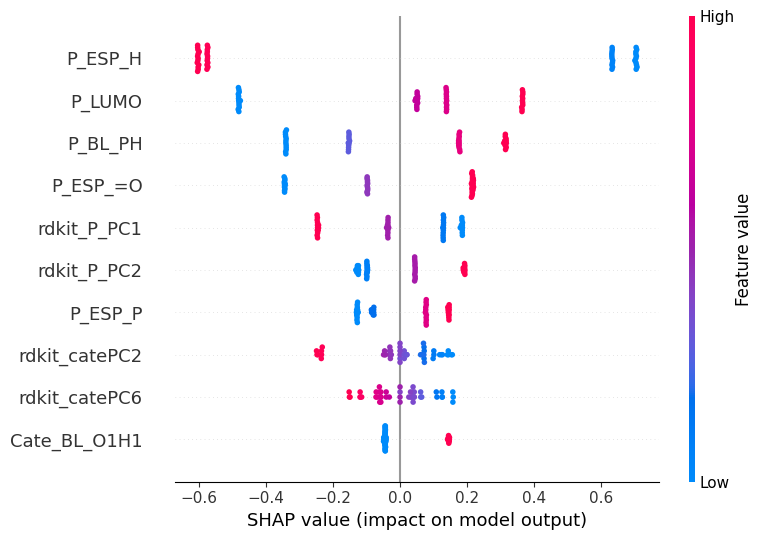

In [8]:
#shap
explainer = shap.KernelExplainer(reg_best.predict,a_X_train)
shap_values = explainer.shap_values(X=a_X_train)
shap.summary_plot(shap_values, a_X_train,max_display=10)